In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mhb-dataset/data/images/ID_268b38fe_ID_d747ae3ffb_slice_025.png
/kaggle/input/mhb-dataset/data/images/ID_14058625_ID_527c581583_slice_024.png
/kaggle/input/mhb-dataset/data/images/ID_c9d6fdc6_ID_7f09be285d_slice_022.png
/kaggle/input/mhb-dataset/data/images/ID_a2ddcdfe_ID_d7aedfd21f_slice_017.png
/kaggle/input/mhb-dataset/data/images/ID_9ed18606_ID_8cfe740d83_slice_008.png
/kaggle/input/mhb-dataset/data/images/ID_55742eb7_ID_7d5ad548ca_slice_017.png
/kaggle/input/mhb-dataset/data/images/ID_e393f193_ID_c81bf5f45d_slice_006.png
/kaggle/input/mhb-dataset/data/images/ID_2e21c3f3_ID_bc8f99a0cc_slice_022.png
/kaggle/input/mhb-dataset/data/images/ID_77cd921b_ID_e0d0a5f299_slice_018.png
/kaggle/input/mhb-dataset/data/images/ID_f335b6db_ID_d180629430_slice_018.png
/kaggle/input/mhb-dataset/data/images/ID_3bda60be_ID_067209cc9a_slice_022.png
/kaggle/input/mhb-dataset/data/images/ID_552aabb9_ID_152fdcf86e_slice_009.png
/kaggle/input/mhb-dataset/data/images/ID_9dce269b_ID_4191982e02_

In [2]:
!pip install numpy SimpleITK tqdm pillow torch torchvision scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9.90:
      Successfully uninstalled nvidia-curand-cu12-10.3.9.90
  Attemptin

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv2D -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Pad x1 if needed to match x2's spatial dimensions
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNetLite(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNetLite, self).__init__()
        self.inc = DoubleConv(in_channels, 32)  # Reduced from 64 to 32
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)           # Stop at 256 instead of 1024
        self.up1 = Up(256, 128)
        self.up2 = Up(128, 64)
        self.up3 = Up(64, 32)
        self.outc = nn.Conv2d(32, out_channels, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits


"""class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits"""

'class UNet(nn.Module):\n    def __init__(self, in_channels=1, out_channels=1):\n        super(UNet, self).__init__()\n        self.inc = DoubleConv(in_channels, 64)\n        self.down1 = Down(64, 128)\n        self.down2 = Down(128, 256)\n        self.down3 = Down(256, 512)\n        self.down4 = Down(512, 1024)\n        self.up1 = Up(1024, 512)\n        self.up2 = Up(512, 256)\n        self.up3 = Up(256, 128)\n        self.up4 = Up(128, 64)\n        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)\n    \n    def forward(self, x):\n        x1 = self.inc(x)\n        x2 = self.down1(x1)\n        x3 = self.down2(x2)\n        x4 = self.down3(x3)\n        x5 = self.down4(x4)\n        x = self.up1(x5, x4)\n        x = self.up2(x, x3)\n        x = self.up3(x, x2)\n        x = self.up4(x, x1)\n        logits = self.outc(x)\n        return logits'

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
import multiprocessing

class SliceDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img = Image.open(self.image_paths[idx])
        img_array = np.array(img)
        
        # Load mask
        mask = Image.open(self.mask_paths[idx])
        mask_array = np.array(mask)
        
        # Apply transforms if specified
        if self.transform:
            img_array = self.transform(img_array)
        else:
            # Convert to tensor and normalize
            img_array = img_array.astype(np.float32) / 255.0
            img_array = torch.tensor(img_array, dtype=torch.float32).unsqueeze(0)  # Add channel dim: (1, H, W)
        
        # Convert mask to tensor (no normalization for masks)
        mask_tensor = torch.tensor(mask_array, dtype=torch.long)  # (H, W)
        
        return img_array, mask_tensor

def get_dataset_paths():
    """Get all paired image and mask paths"""
    image_dir = '/kaggle/input/mhb-dataset/data/images'
    mask_dir = '/kaggle/input/mhb-dataset/data/masks'
    
    # Get all PNG files in the image directory
    all_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]
    all_images.sort()  # Ensure consistent ordering
    
    # Create corresponding mask paths
    all_masks = []
    valid_images = []
    
    for img_path in all_images:
        # Get the corresponding mask path
        filename = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, filename)
        
        # Only include if both image and mask exist
        if os.path.exists(mask_path):
            valid_images.append(img_path)
            all_masks.append(mask_path)
    
    print(f"Found {len(valid_images)} valid image-mask pairs")
    return valid_images, all_masks

def create_data_loaders(batch_size=64, val_split=0.15, test_split=0.15, seed=42, num_workers=8):
    """Create train, validation and test data loaders"""
    # Set random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Get image and mask paths
    image_paths, mask_paths = get_dataset_paths()
    
    # Split into train, validation, and test sets
    train_imgs, test_imgs, train_masks, test_masks = train_test_split(
        image_paths, mask_paths, test_size=test_split, random_state=seed
    )
    
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        train_imgs, train_masks, test_size=val_split/(1-test_split), random_state=seed
    )
    
    print(f"Training: {len(train_imgs)} samples")
    print(f"Validation: {len(val_imgs)} samples")
    print(f"Testing: {len(test_imgs)} samples")
    
    # Create datasets
    train_dataset = SliceDataset(train_imgs, train_masks)
    val_dataset = SliceDataset(val_imgs, val_masks)
    test_dataset = SliceDataset(test_imgs, test_masks)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, test_loader

def get_class_weights(mask_paths, num_classes=6):
    """Calculate class weights to handle class imbalance"""
    class_counts = np.zeros(num_classes)
    
    print("Calculating class distribution...")
    for mask_path in mask_paths:
        mask = np.array(Image.open(mask_path))
        for c in range(num_classes):
            class_counts[c] += np.sum(mask == c)
    
    # Calculate weights (inverse frequency)
    total_pixels = np.sum(class_counts)
    class_weights = total_pixels / (class_counts * num_classes)
    
    # Replace infinities with a large number
    class_weights = np.nan_to_num(class_weights, nan=1.0, posinf=10.0, neginf=1.0)
    
    return torch.FloatTensor(class_weights)

In [5]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import multiprocessing
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import logging
import datetime
import csv

# Set up logging
def setup_logging():
    """Set up the logging system"""
    # Create logs directory if it doesn't exist
    os.makedirs('logs', exist_ok=True)
    
    # Set up file name with timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = f"logs/training_{timestamp}.log"
    
    # Configure logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()  # Also print to console
        ]
    )
    
    return log_file, timestamp

# Set up CSV logging for batch-level metrics
def setup_batch_logging(timestamp):
    """Set up CSV logging for batch-level metrics"""
    batch_log_file = f"logs/batch_metrics_{timestamp}.csv"
    
    # Create CSV file with headers
    with open(batch_log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Epoch', 'Batch', 'Loss', 'Dice_BG', 'Dice_EDH', 'Dice_IPH', 'Dice_IVH', 'Dice_SAH', 'Dice_SDH', 'Mean_Dice'])
    
    return batch_log_file

# Define metrics for semantic segmentation
def calculate_iou(pred, target, n_classes=6):
    """Calculate IoU (Intersection over Union) for each class"""
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    # For each class
    for cls in range(n_classes):
        # True Positive (TP): prediction is cls and ground truth is cls
        pred_cls = pred == cls
        target_cls = target == cls
        
        intersection = (pred_cls & target_cls).sum()
        union = (pred_cls | target_cls).sum()
        
        if union.item() == 0:
            # If there is no ground truth of this class in this image, ignore it
            iou = torch.tensor(1.0)
        else:
            iou = intersection.float() / union.float()
        
        ious.append(iou.item())
    
    return ious

def calculate_dice(pred, target, n_classes=6):
    """Calculate Dice coefficient for each class"""
    dices = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    # For each class
    for cls in range(n_classes):
        pred_cls = pred == cls
        target_cls = target == cls
        
        intersection = (pred_cls & target_cls).sum()
        cardinality = pred_cls.sum() + target_cls.sum()
        
        if cardinality.item() == 0:
            # If there is no ground truth and no prediction of this class, dice = 1
            dice = torch.tensor(1.0)
        else:
            dice = (2.0 * intersection) / cardinality
        
        dices.append(dice.item())
    
    return dices

def log_batch_metrics(batch_log_file, epoch, batch_idx, loss, dices):
    """Log batch metrics to CSV file"""
    mean_dice = np.mean(dices)
    
    with open(batch_log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch, batch_idx, loss] + dices + [mean_dice])

def train():
    # Set up logging
    log_file, timestamp = setup_logging()
    batch_log_file = setup_batch_logging(timestamp)
    
    logging.info("Starting training with multiclass hemorrhage segmentation")
    
    # Create output directory for results
    os.makedirs('results', exist_ok=True)
    
    # Create data loaders with appropriate batch size and no workers for Windows
    train_loader, val_loader, test_loader = create_data_loaders(batch_size=8, num_workers=2)
    
    # Get class weights for handling imbalance
    image_paths, mask_paths = get_dataset_paths()
    class_weights = get_class_weights(mask_paths)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"Using device: {device}")
    
    # Set class weights for loss function
    class_weights = class_weights.to(device)
    logging.info(f"Class weights: {class_weights.cpu().numpy()}")
    
    # Define model
    model = UNetLite(in_channels=1, out_channels=6).to(device)  # 6 classes: background + 5 hemorrhage types
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    logging.info(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
    
    # Use weighted CrossEntropyLoss for multiclass segmentation
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Training tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    class_names = ['Background', 'EDH', 'IPH', 'IVH', 'SAH', 'SDH']
    
    # Train for specified epochs
    num_epochs = 200
    logging.info(f"Starting training for {num_epochs} epochs")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_dice_scores = np.zeros(6)
        batch_count = 0
        
        # Training loop
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (images, masks) in enumerate(progress_bar):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)  # Shape: (B, 6, H, W)
            loss = criterion(outputs, masks)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Get predictions and calculate Dice score
            preds = torch.argmax(outputs, dim=1)
            batch_dices = calculate_dice(preds, masks)
            epoch_dice_scores += np.array(batch_dices)
            batch_count += 1
            
            # Log batch metrics
            log_batch_metrics(batch_log_file, epoch+1, batch_idx+1, loss.item(), batch_dices)
            
            # Update progress bar
            running_loss += loss.item()
            mean_dice = np.mean(batch_dices)
            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Dice": f"{mean_dice:.4f}"
            })
        
        # Average training metrics for epoch
        avg_train_loss = running_loss / len(train_loader)
        avg_train_dice = epoch_dice_scores / batch_count
        mean_train_dice = np.mean(avg_train_dice)
        
        train_losses.append(avg_train_loss)
        
        # Log epoch training metrics
        logging.info(f"Epoch {epoch+1}/{num_epochs}")
        logging.info(f"  Train Loss: {avg_train_loss:.4f}, Mean Dice: {mean_train_dice:.4f}")
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        class_ious = np.zeros(6)
        class_dices = np.zeros(6)
        val_samples = 0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validation"):
                images = images.to(device)
                masks = masks.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Get predictions
                preds = torch.argmax(outputs, dim=1)
                
                # Calculate IoU and Dice for each batch
                ious = calculate_iou(preds, masks)
                dices = calculate_dice(preds, masks)
                
                # Accumulate metrics
                class_ious += np.array(ious)
                class_dices += np.array(dices)
                val_samples += 1
        
        # Average validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        avg_class_ious = class_ious / val_samples
        avg_class_dices = class_dices / val_samples
        
        # Calculate mean metrics
        mean_iou = np.mean(avg_class_ious)
        mean_dice = np.mean(avg_class_dices)
        
        # Log validation metrics
        logging.info(f"  Val Loss: {avg_val_loss:.4f}, Mean IoU: {mean_iou:.4f}, Mean Dice: {mean_dice:.4f}")
        logging.info("  Per-class validation metrics:")
        
        for i, class_name in enumerate(class_names):
            logging.info(f"    {class_name}: IoU={avg_class_ious[i]:.4f}, Dice={avg_class_dices[i]:.4f}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'results/best_segmentation_model.pth')
            logging.info("  New best model saved!")
    
    # Save final model
    torch.save(model.state_dict(), 'results/final_segmentation_model.pth')
    logging.info("Final model saved")
    
    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('results/loss_curve.png')
    logging.info("Loss curve saved to results/loss_curve.png")
    
    # Test the final model
    test_model(model, test_loader, device, class_names)
    
    logging.info("Training complete!")

def test_model(model, test_loader, device, class_names):
    """Evaluate model performance on test set"""
    logging.info("Evaluating model on test set")
    
    model.eval()
    class_ious = np.zeros(6)
    class_dices = np.zeros(6)
    test_samples = 0
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(test_loader, desc="Testing")):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Calculate metrics
            ious = calculate_iou(preds, masks)
            dices = calculate_dice(preds, masks)
            
            # Accumulate metrics
            class_ious += np.array(ious)
            class_dices += np.array(dices)
            test_samples += 1
            
            # Save a few example predictions for visualization
            if i < 5:
                save_prediction_sample(images, masks, preds, i, class_names)
    
    # Average test metrics
    avg_class_ious = class_ious / test_samples
    avg_class_dices = class_dices / test_samples
    
    # Calculate mean metrics
    mean_iou = np.mean(avg_class_ious)
    mean_dice = np.mean(avg_class_dices)
    
    logging.info("\nTest Results:")
    logging.info(f"  Mean IoU: {mean_iou:.4f}")
    logging.info(f"  Mean Dice: {mean_dice:.4f}")
    
    # Log per-class metrics
    logging.info("  Per-class test metrics:")
    for i, class_name in enumerate(class_names):
        logging.info(f"    {class_name}: IoU={avg_class_ious[i]:.4f}, Dice={avg_class_dices[i]:.4f}")

def save_prediction_sample(images, masks, preds, sample_idx, class_names):
    """Save visualization of predictions"""
    # Move tensors to CPU and convert to numpy
    image = images[0].cpu().numpy()[0]  # First image in batch, remove channel dim
    mask = masks[0].cpu().numpy()       # First mask in batch
    pred = preds[0].cpu().numpy()       # First prediction in batch
    
    # Create a colormap for visualization
    cmap = plt.cm.get_cmap('viridis', len(class_names))
    
    plt.figure(figsize=(15, 5))
    
    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap=cmap, vmin=0, vmax=len(class_names)-1)
    plt.colorbar(ticks=range(len(class_names)), label='Class')
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Plot prediction
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap=cmap, vmin=0, vmax=len(class_names)-1)
    plt.colorbar(ticks=range(len(class_names)), label='Class')
    plt.title('Prediction')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'results/sample_{sample_idx}.png')
    plt.close()

Found 2403 valid image-mask pairs
Training: 1681 samples
Validation: 361 samples
Testing: 361 samples
Found 2403 valid image-mask pairs
Calculating class distribution...


Testing:   0%|          | 0/46 [00:00<?, ?it/s]/tmp/ipykernel_19/4107085622.py:325: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(class_names))
Testing: 100%|██████████| 46/46 [00:06<00:00,  6.70it/s]


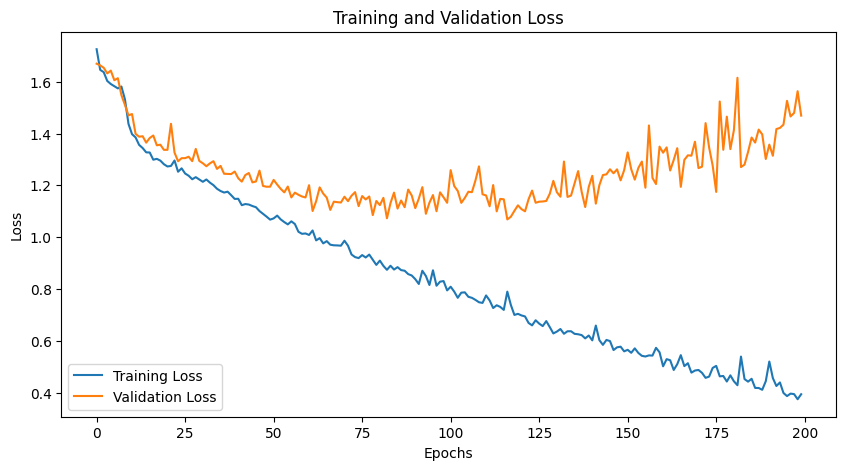

In [6]:

torch.backends.cudnn.benchmark = True
multiprocessing.freeze_support()
train()